In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.insert(1, '../../yukun_disentanglement_lib/')
sys.path.insert(0, '../source_tf/utils')
sys.path.insert(0, '../source_tf/models')
from keras import metrics
import tensorflow_hub as hub
import tensorflow as tf
import yukun_disentanglement_lib
from yukun_disentanglement_lib.data.ground_truth import celeba, celebaHR
from data_helpers import DataProvider
from simgan_models import simgan_decoder, simgan_decoder_hr, simgan_discriminator, simgan_encoder
from dsvae_model_large import DSVAEL, loss_function
# from dsvae_model import DSVAE, loss_function
import numpy as np
import time, math
from misc import merge
import argparse
import wandb
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import torch

Using TensorFlow backend.


In [2]:
log = True
if log:
    wandb.init(project="pytorch_dsvae", name="celeba_10k_large_relu_sb")

# Load the data

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--z_dim", help="z dimension", default=85, type=int)
parser.add_argument("--device", help="gpu id", default=1, type=int)
parser.add_argument("--nb_epochs", help="number of epochs", default=500, type=int)
parser.add_argument("--start_epoch", help="epoch to start training from (requires checkpoints)", default=0, type=int)
parser.add_argument("--save_interval", help="epochs to save model", default=10, type=int)
parser.add_argument("--run_seed", help="run seed of TCVAE", default=100, type=int)
parser.add_argument("--lr", help="learning rate", default=.0001, type=float)
parser.add_argument("--batch_size", help="batch size", default=32, type=int)
args = parser.parse_args([])

if log:
    wandb.config.update(args)

device = args.device
print("z_dim: {}".format(args.z_dim))
print("GPU: {}".format(device))
print("start_epoch: {}".format(args.start_epoch))
print("save_interval: {}".format(args.save_interval))

#path to classifier
classifier_url = '../../tcvae_models/celeba10/train_output/d_15_b_15_{}/tfhub/'.format(0)
# classifier_url = '../../tcvae_models/celeba/train_output/100k/d_15_b_15_{}/tfhub/'.format(args.run_seed)
print("Classifier URL")
print(classifier_url)
classifier = hub.Module(classifier_url)
num_samples=10000
dta = celeba.CelebA(celeba_path="../../yukun_disentanglement_lib/img_align_celeba", num_samples=num_samples)

wandb: Wandb version 0.8.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


z_dim: 85
GPU: 1
start_epoch: 0
save_interval: 10
Classifier URL
../../tcvae_models/celeba10/train_output/d_15_b_15_0/tfhub/
10000
finish reading face images
(10000, 64, 64, 3)


In [4]:
# celeba from yukun_dis_lib
load = True
save = True
num_y_samples = 10
tf.set_random_seed(1)
if not load:
    raw_pics = np.float32(np.empty((num_samples, num_y_samples, 64, 64,3)))
    with hub.eval_function_for_module(classifier_url) as f:
        for j in range(num_y_samples):
            raw_pic = []
            for i in range(10):
                real_pics = np.float32(dta.images[i*int(num_samples/10):(i+1)*int(num_samples/10)])
                raw_pic.append(f(dict(images=real_pics), signature="reconstructions", as_dict=True)["images"]) 
            raw_pics[:,j] = np.float32(np.concatenate(raw_pic,axis=0))
    inputs = np.float32(dta.images)
    targets = np.float32(raw_pics)
    if save:
        np.save('data_lr/inputs_10k_sample', inputs)
        np.save('data_lr/targets_10k_sample', targets)     
else:  
    inputs = np.load('data_lr/inputs_10k_sample.npy')
    targets = np.load('data_lr/targets_10k_sample.npy')

In [5]:
torch_inputs = torch.from_numpy(inputs).permute(0,3,1,2)
torch_targets = torch.from_numpy(targets).permute(0,1,4,2,3)

In [6]:
from pytorch_data_utils import DSVAE_DATA
torch_dataset = DSVAE_DATA(torch_inputs, torch_targets)
torch_data_loader = torch.utils.data.DataLoader(torch_dataset, batch_size=args.batch_size, shuffle=True)

In [7]:
def plot_pytorch_images(images, num_images=5, title=""):
    if images.is_cuda:
        images = images.detach().cpu()
    images = images.permute(0,2,3,1)
    img = np.expand_dims(images,0)
    img = merge(img[0],[1,num_images])
    fig = plt.figure(figsize=(8*max(1, num_images-2),8))
    plt.imshow(img)
    plt.gray()
    plt.title(title)
    plt.show()
    return fig

In [8]:
if args.device != -1:
    dsvae = DSVAEL(z_dim=85, device=args.device)
    dsvae.to(device)
else:
    dsvae = DSVAEL(z_dim=85, device=None)
optimizer = torch.optim.Adam(params=dsvae.parameters(), lr=args.lr)

wandb: Wandb version 0.8.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training for 1500 epochs...


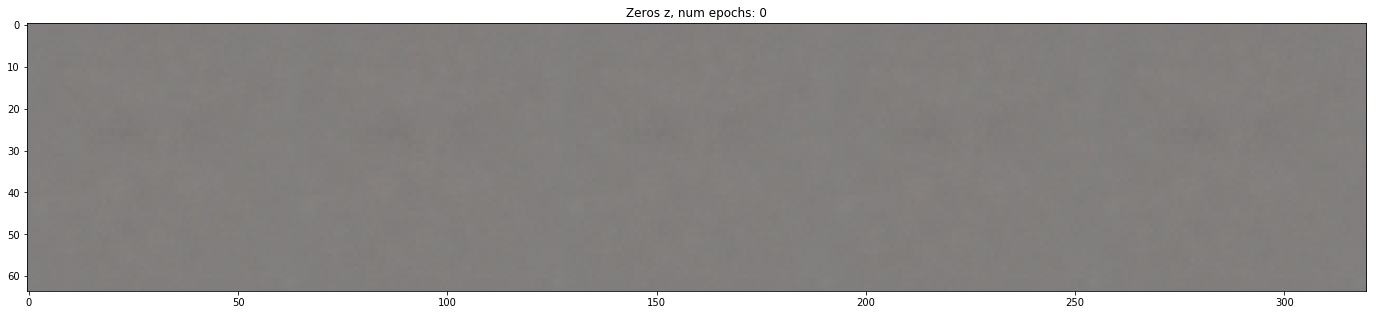

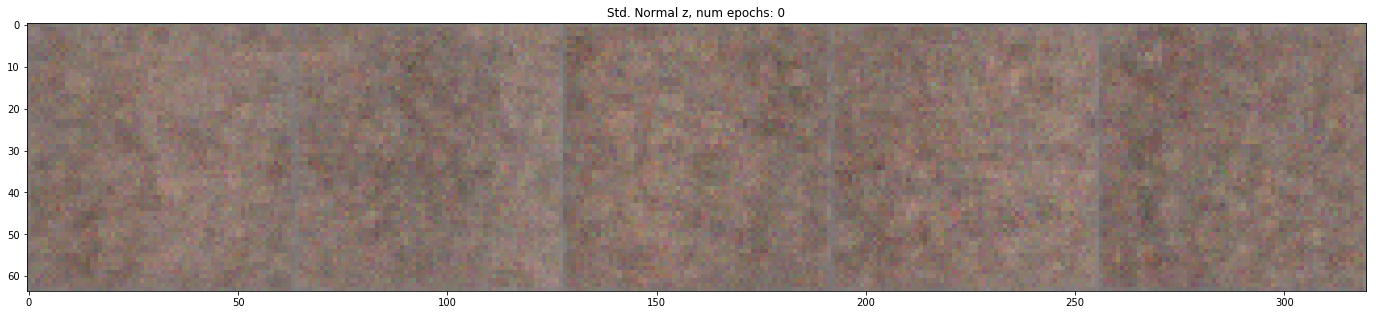

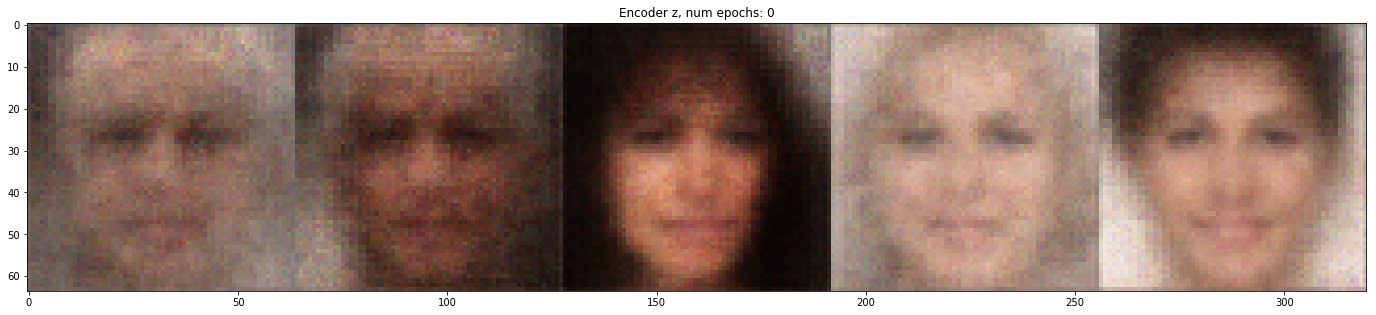

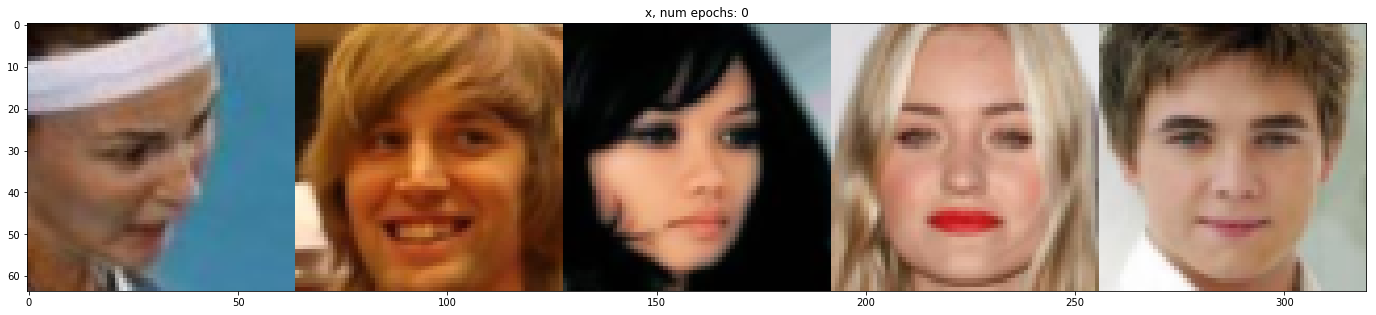

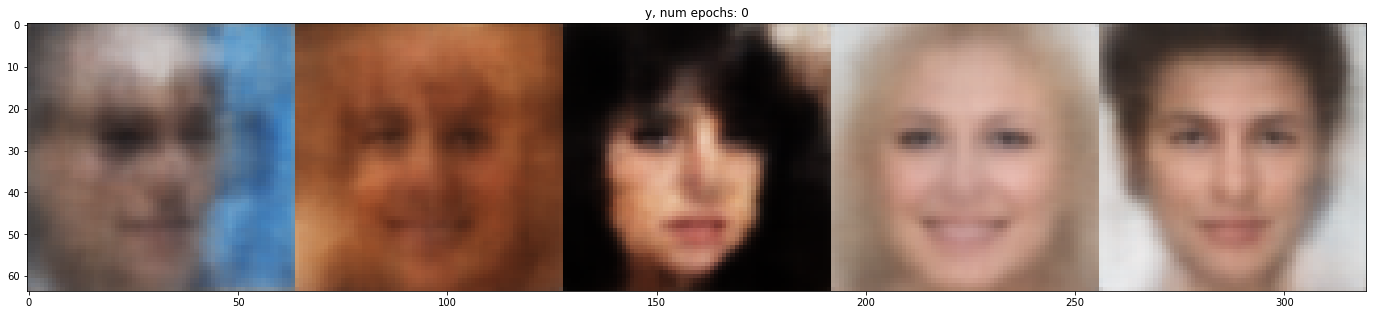

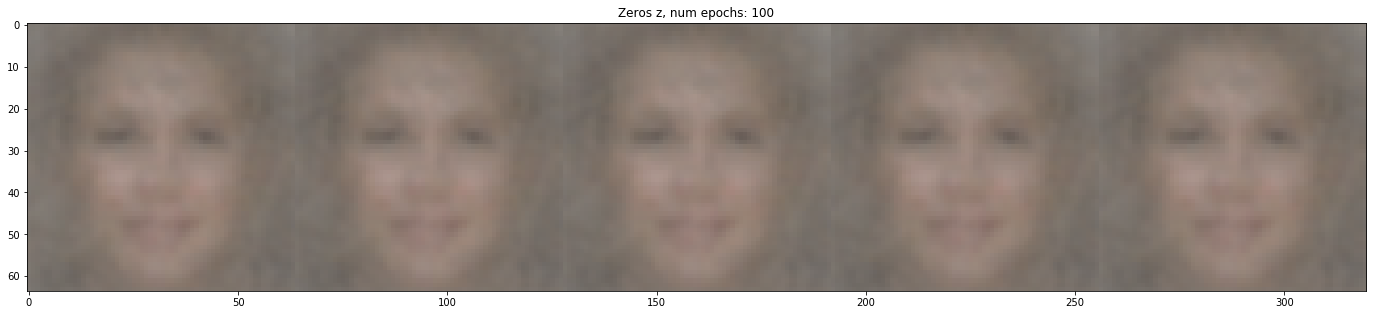

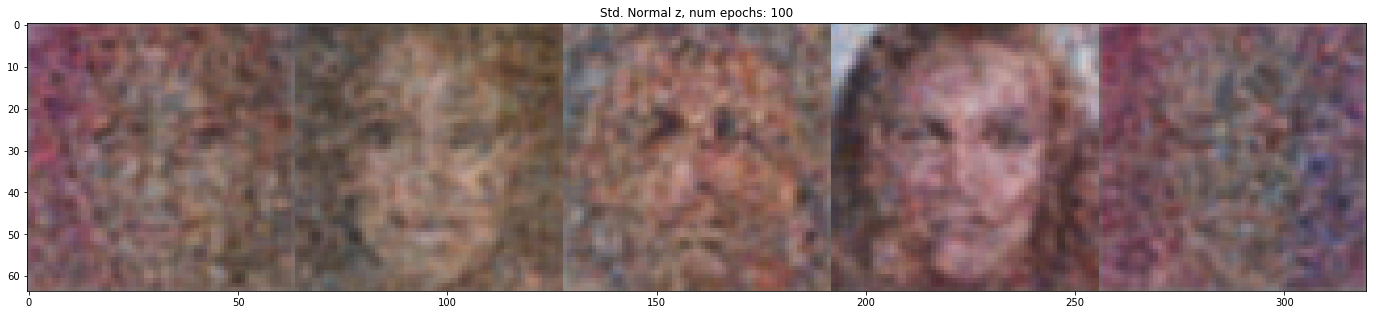

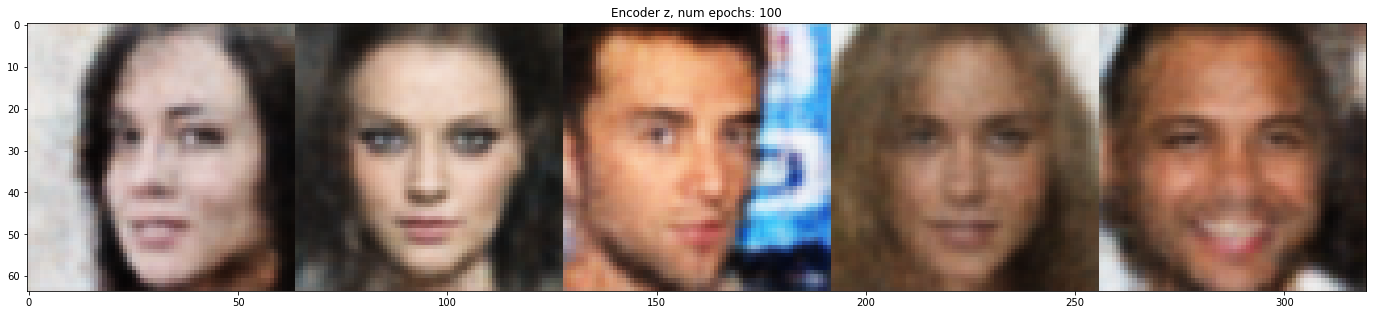

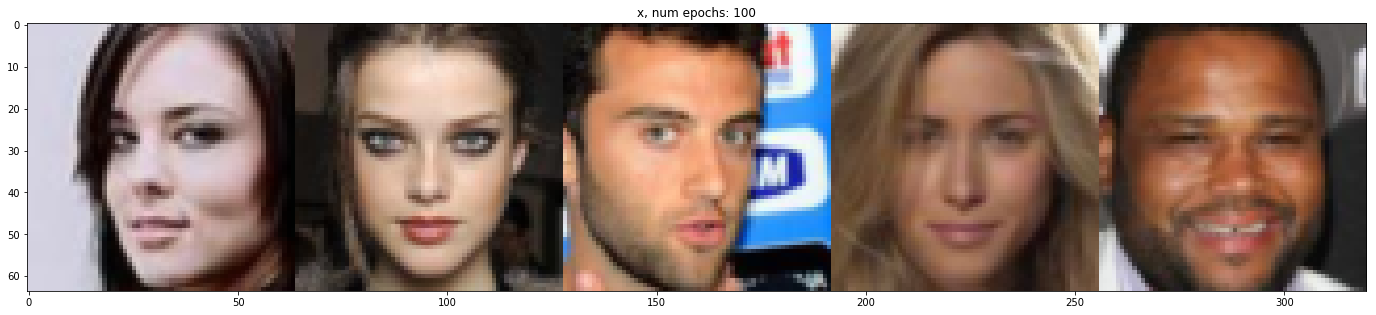

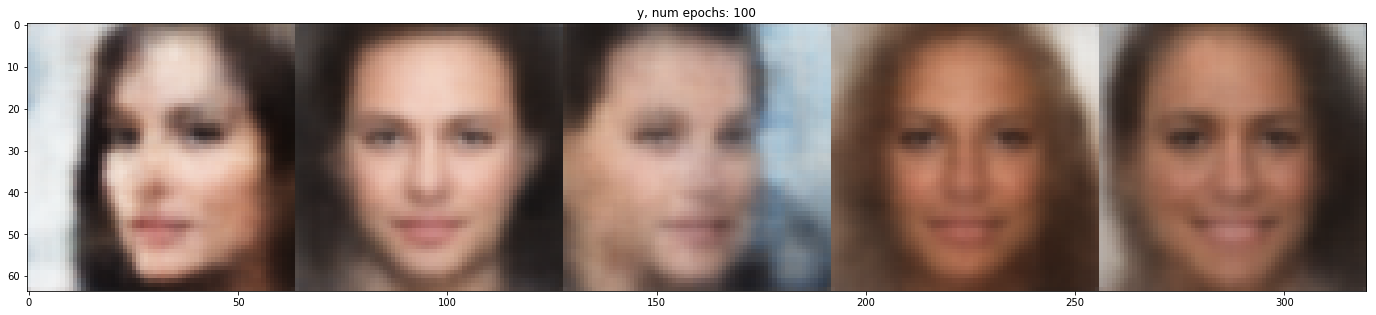

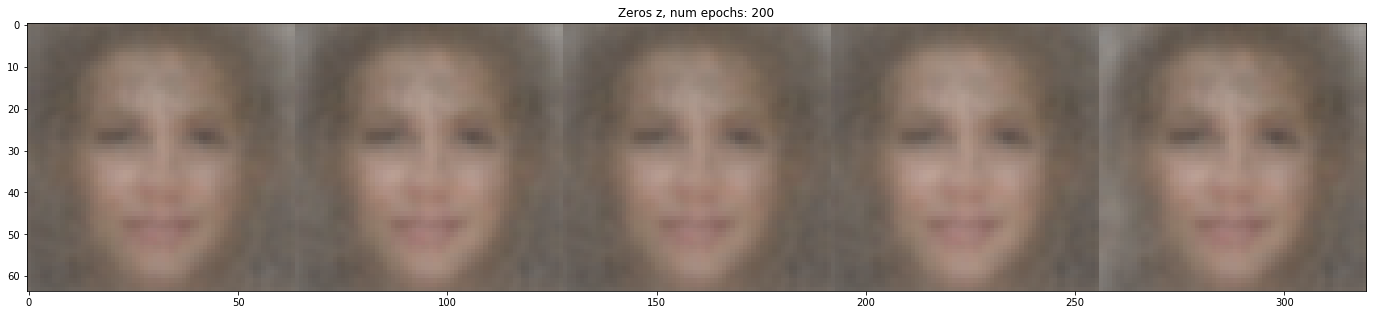

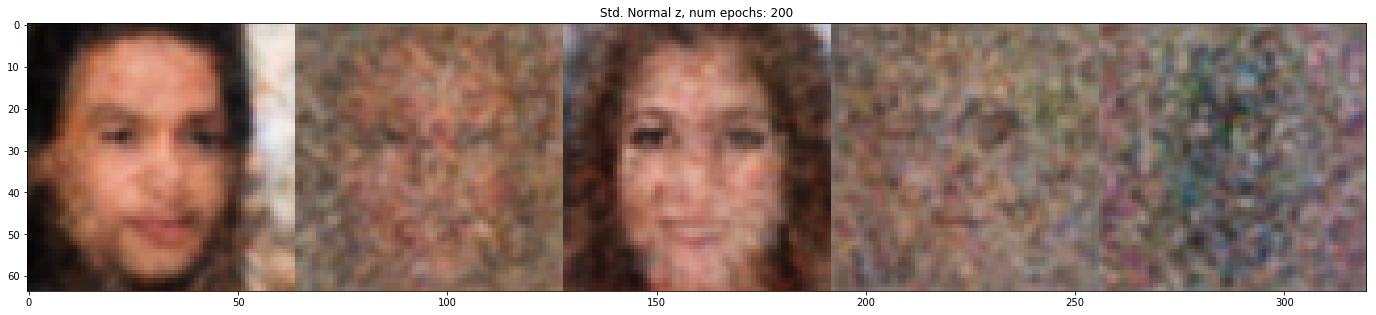

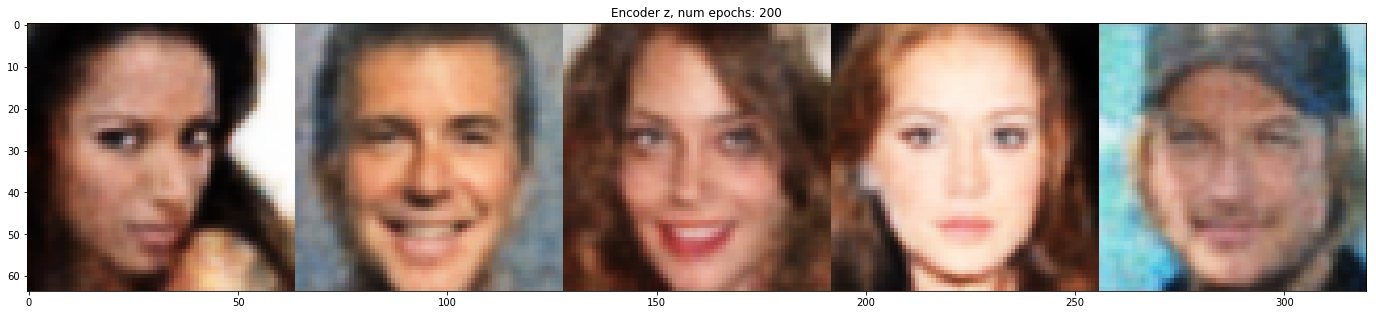

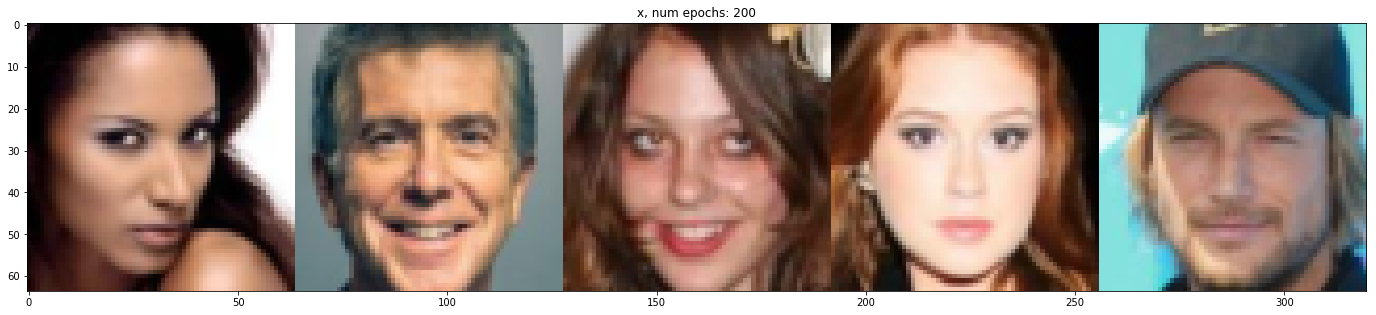

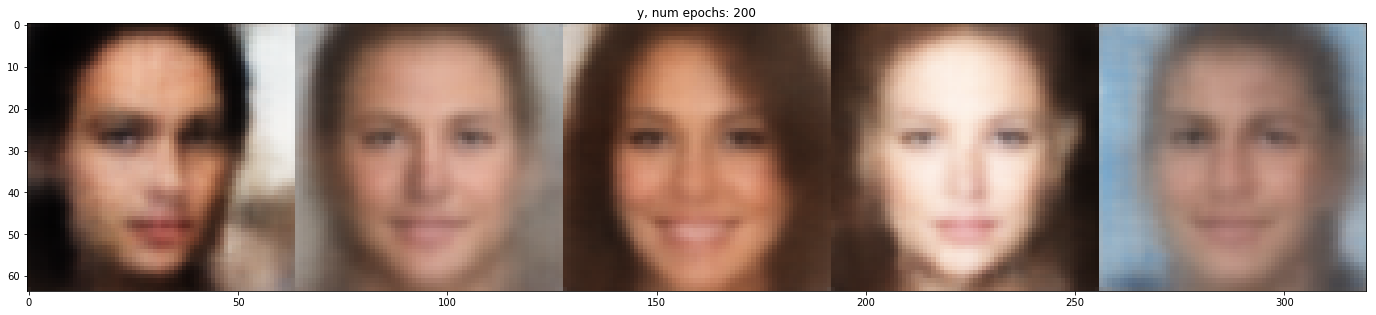

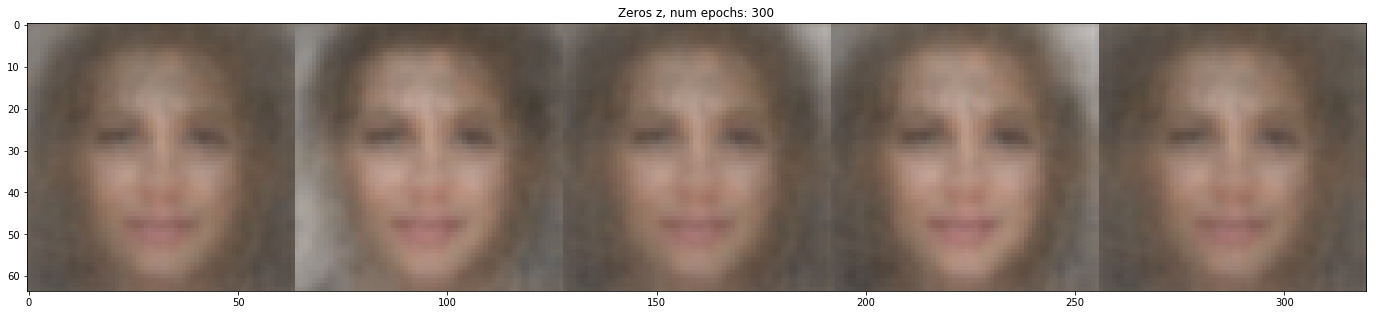

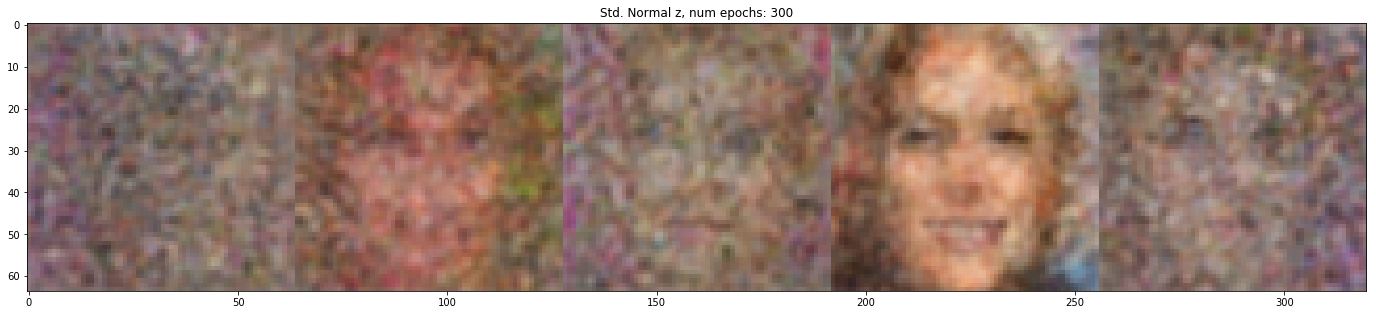

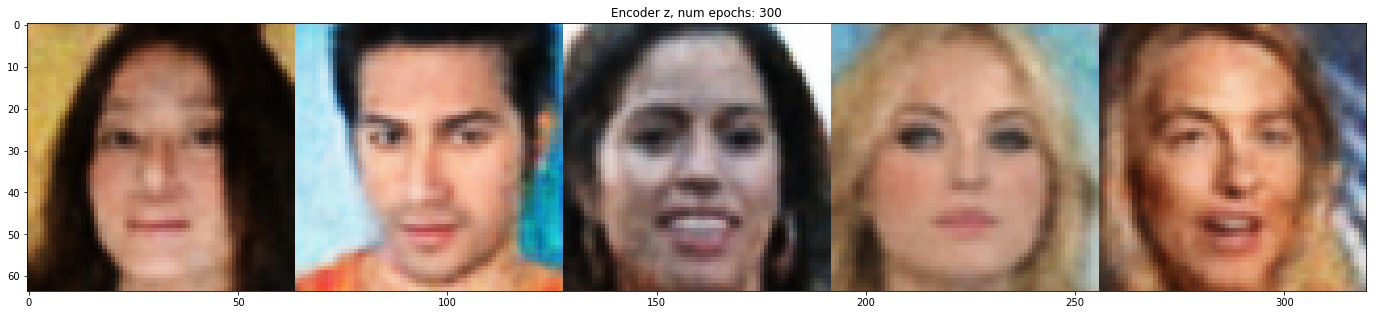

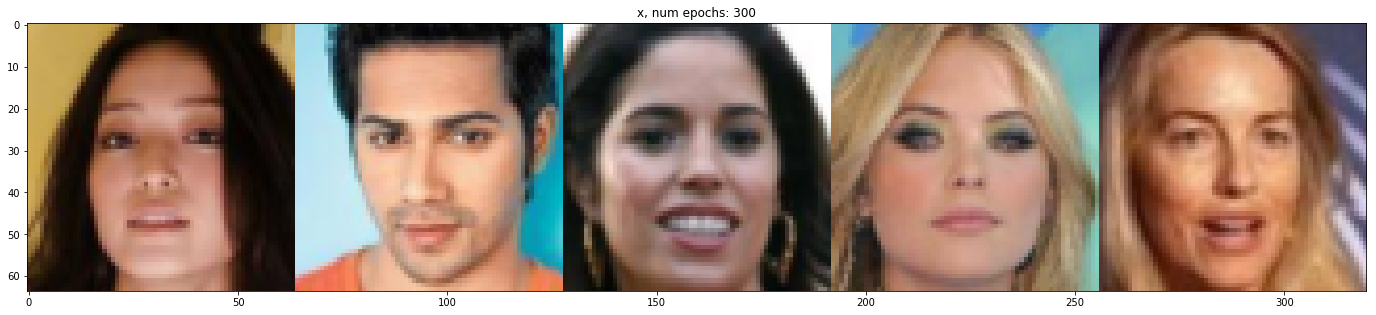

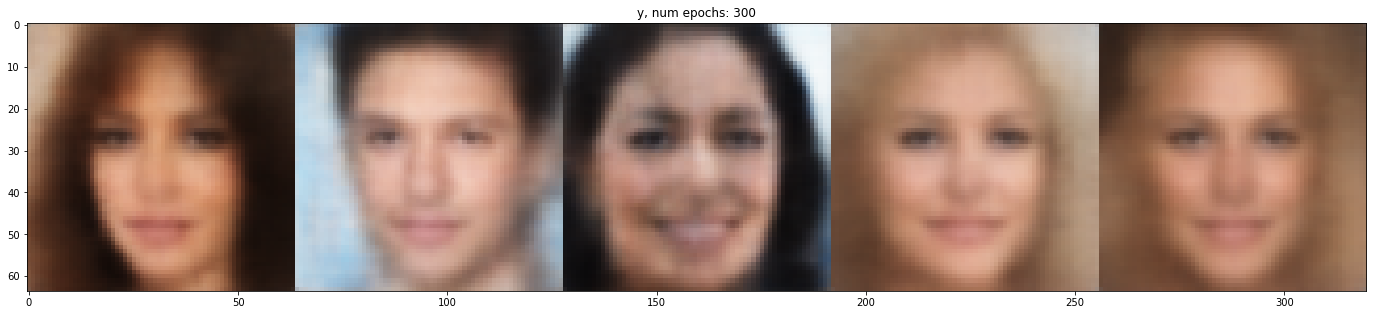

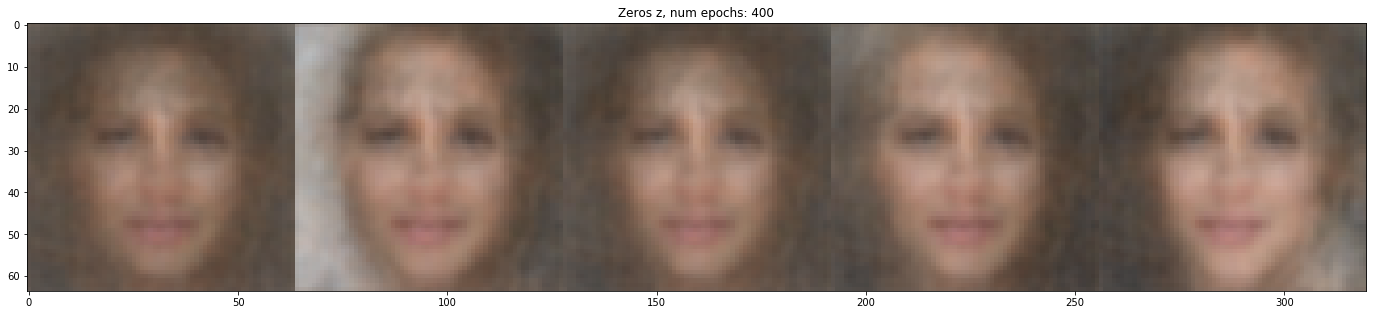

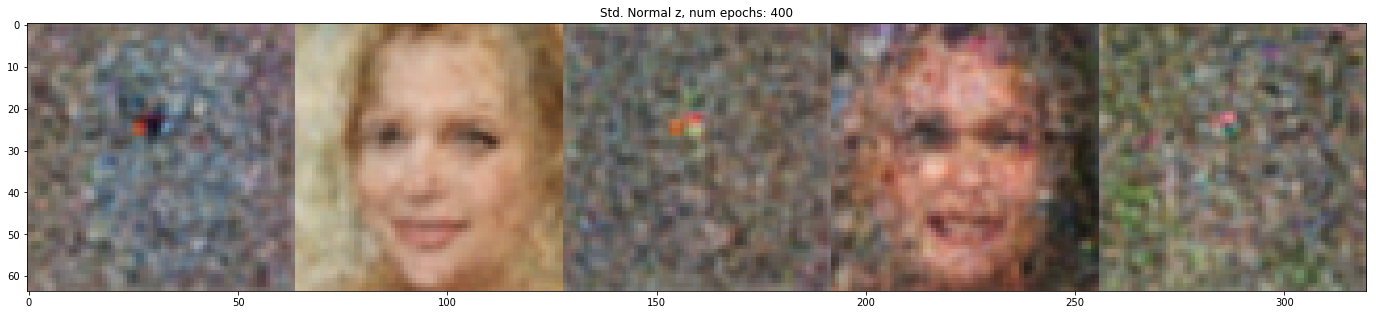

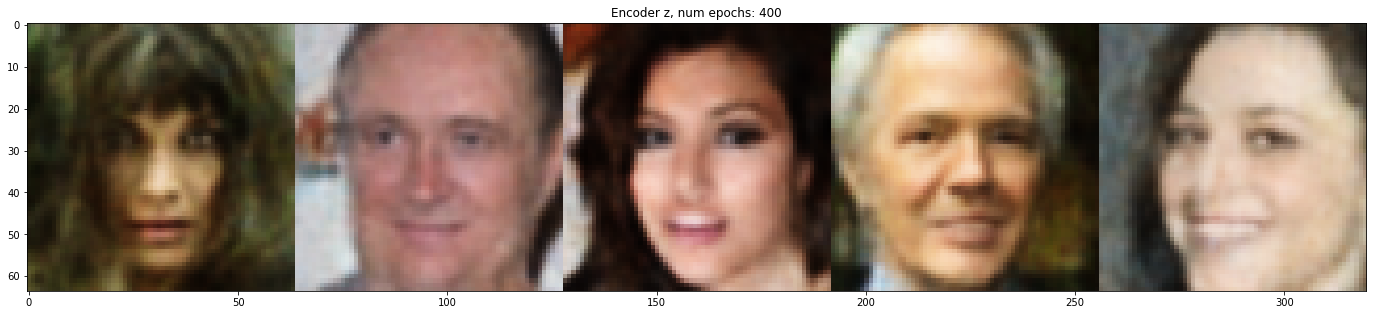

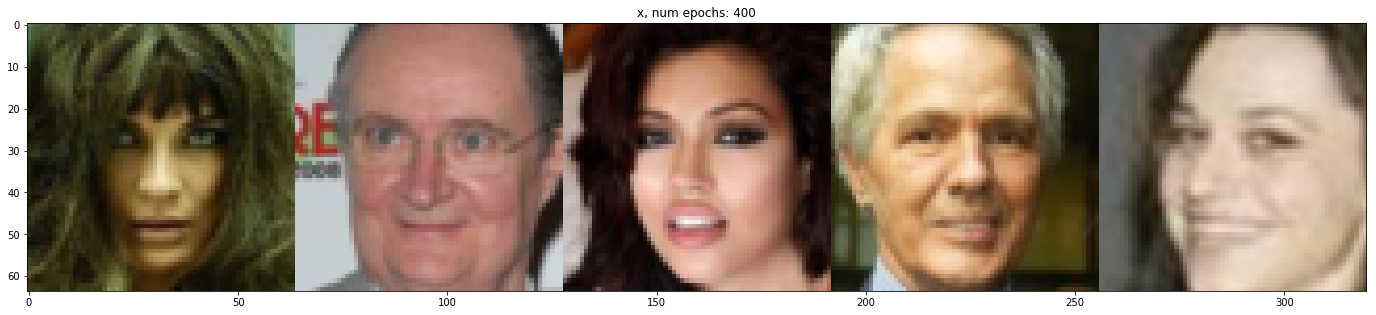

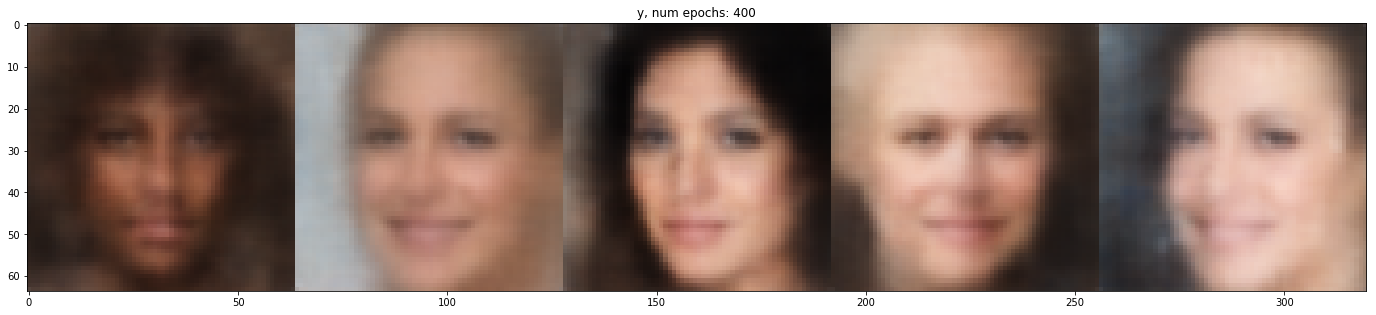

KeyboardInterrupt: 

In [9]:
dsvae.train()
normal = torch.distributions.Normal(0,1)
print("Training for {} epochs...".format(1500))
for n in range(0, 3000):
    for (i, X) in enumerate(torch_data_loader):
        x = X[0]
        y_all = X[1]
        rand_int = np.random.randint(0,num_y_samples)
        y = y_all[:,rand_int]
        if dsvae.cuda:
            x = x.to(device)
            y = y.to(device)
        optimizer.zero_grad()
        x_hat, z_mu, z_var = dsvae(x, y)
        loss, recon_loss, kl_loss = loss_function(x_hat, x, z_mu, z_var)
        if log:
            wandb.log({'loss':loss})
            wandb.log({'recon_loss':recon_loss})
            wandb.log({'kl_loss':kl_loss})
        loss.backward()
        optimizer.step()

    if n%100 ==0:
        dsvae.eval() #evaluate model
        z_noise = normal.sample((x.shape[0],85))
        z_zeros = torch.zeros((x.shape[0],85))
        if dsvae.cuda:
            z_noise = z_noise.to(device)
            z_zeros = z_zeros.to(device)
        x_hat_noise = dsvae.decode(y,z_noise)
        x_hat_zeros = dsvae.decode(y,z_zeros)
        
        fig = plot_pytorch_images(x_hat_zeros[:5], num_images=5, title='Zeros z, num epochs: {}'.format(n))
        if log:
            wandb.log({'Zeros z':fig})
            
        fig = plot_pytorch_images(x_hat_noise[:5], num_images=5, title='Std. Normal z, num epochs: {}'.format(n))
        if log:
            wandb.log({'Std. Normal z':fig})
            
        fig = plot_pytorch_images(x_hat[:5], num_images=5, title='Encoder z, num epochs: {}'.format(n))
        if log:
            wandb.log({'Encoder z':fig})
            
        fig = plot_pytorch_images(x[:5], num_images=5, title='x, num epochs: {}'.format(n))
        if log:
            wandb.log({'x':fig})

        fig = plot_pytorch_images(torch.sigmoid(y[:5]), num_images=5, title='y, num epochs: {}'.format(n))
        if log:
            wandb.log({'y':fig})   
        dsvae.train() #back to training model

In [12]:
# torch.save(dsvae, "dsvae_large_lr_2000")

In [10]:
# dsvae = torch.load("saved_models/dsvae_large_lr_2000")

/root/anaconda3/envs/tensorflow_gpu/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'dsvae_model_large.DSVAEL' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [ ]:
import numbers
import os
from yukun_disentanglement_lib.data.ground_truth import named_data
from yukun_disentanglement_lib.utils import results
from yukun_disentanglement_lib.visualize import visualize_util
from yukun_disentanglement_lib.visualize.visualize_irs import vis_all_interventional_effects
import numpy as np
from scipy import stats
from six.moves import range
from tensorflow import gfile
import gin.tf
from yukun_disentanglement_lib.visualize.visualize_model import latent_traversal_1d_multi_dim, sigmoid, tanh, latent_traversal_1d_multi_dim_dsvae, latent_traversal_1d_multi_dim_dsvae_new

output_dir = 'visualize_output_sample'
print(output_dir)
dlib_model_path = '/hdd/dsvae/tcvae_models/celeba10/train_output/d_15_b_15_{}/'.format(0)
model_dir = os.path.join(dlib_model_path, '')
overwrite=True
num_animations=5
num_frames=32
fps=10
num_points_irs=10000
# Create the output directory if necessary.
if tf.gfile.IsDirectory(output_dir):
    if overwrite:
        tf.gfile.DeleteRecursively(output_dir)
    else:
        raise ValueError("Directory already exists and overwrite is False.")

gin_config_file = os.path.join(model_dir, "results", "gin", "train.gin")
print(gin_config_file)
gin_dict = results.gin_dict(gin_config_file)

num_pics = 32
module_path = os.path.join(model_dir, "tfhub")
dsvae.eval()
with hub.eval_function_for_module(module_path) as f:
    # Save reconstructions.
    random_state = np.random.RandomState(2)
    real_pics_hr = dtahr.sample_observations(num_pics, random_state)
    random_state = np.random.RandomState(2)
    real_pics = dta.sample_observations(num_pics, random_state)
    raw_pics = f(dict(images=real_pics), signature="reconstructions", as_dict=True)["images"]
    pics = sigmoid(raw_pics)
    pics = np.pad(pics, ((0, 0), (32,32), (32,32), (0, 0)), 'constant', constant_values=0)

    torch_real_pics = torch.from_numpy(real_pics).permute(0,3,1,2).float()
    torch_raw_pics = torch.from_numpy(raw_pics).permute(0,3,1,2).float()
    
    x_hr_hat, _,_ = dsvae(torch_real_pics, torch_raw_pics)
    x_hr_hat_numpy = x_hr_hat.detach().permute(0,2,3,1).numpy()
        
    paired_pics = np.concatenate((real_pics_hr, pics), axis=2)
    paired_pics = [paired_pics[i, :, :, :] for i in range(paired_pics.shape[0])]
    results_dir = os.path.join(output_dir, "reconstructions")
    if not gfile.IsDirectory(results_dir):
        gfile.MakeDirs(results_dir)
    visualize_util.grid_save_images(
        paired_pics, os.path.join(results_dir, "reconstructions.jpg"))
    paired_pics = np.concatenate((real_pics_hr, pics, x_hr_hat_numpy), axis=2)
    paired_pics = [paired_pics[i, :, :, :] for i in range(paired_pics.shape[0])]
    results_dir = os.path.join(output_dir, "reconstructions")
    if not gfile.IsDirectory(results_dir):
        gfile.MakeDirs(results_dir)
    visualize_util.grid_save_images(
        paired_pics, os.path.join(results_dir, "reconstructions_dsvae.jpg"))
    print("finished reconstructions")
    
    # Save samples
    def _decoder(latent_vectors):
        return f(
          dict(latent_vectors=latent_vectors),
          signature="decoder",
          as_dict=True)["images"]
    num_latent = int(gin_dict["encoder.num_latent"])
    num_pics = 64
    random_codes = random_state.normal(0, 1, [num_pics, num_latent])
    pics = sigmoid(_decoder(random_codes))
    results_dir = os.path.join(output_dir, "sampled")
    if not gfile.IsDirectory(results_dir):
        gfile.MakeDirs(results_dir)
    visualize_util.grid_save_images(pics,
                                    os.path.join(results_dir, "samples.jpg"))
    print("finished samples")
    # Save latent traversals.
    input_images = dta.sample_observations(num_pics, random_state)
    result = f(dict(images=input_images), signature="gaussian_encoder", as_dict=True)
    means = result["mean"]
    logvars = result["logvar"]
    raw_pics = _decoder(means)
    torch_real_pics = torch.from_numpy(input_images).permute(0,3,1,2)
    torch_raw_pics = torch.from_numpy(raw_pics).permute(0,3,1,2)
    x_hr_hat, z_mu, z_var = dsvae(torch_real_pics, torch_raw_pics)
    results_dir = os.path.join(output_dir, "traversals")
    if not gfile.IsDirectory(results_dir):
        gfile.MakeDirs(results_dir)
    for i in range(10):
#         dsvae_pics = latent_traversal_1d_multi_dim_dsvae(dsvae, z_mu[i, :], _decoder, means[i, :])
        dsvae_pics_new = latent_traversal_1d_multi_dim_dsvae_new(dsvae, torch_real_pics[i], _decoder, means[i, :])
        pics = sigmoid(latent_traversal_1d_multi_dim(_decoder, means[i, :], None)) 
        
        file_name = os.path.join(results_dir, "traversals{}.jpg".format(i))
        visualize_util.grid_save_images([pics], file_name)
        
#         file_name = os.path.join(results_dir, "traversals_dsvae{}.jpg".format(i))
#         visualize_util.grid_save_images([dsvae_pics], file_name)
        file_name = os.path.join(results_dir, "traversals_dsvae_new{}.jpg".format(i))
        visualize_util.grid_save_images([dsvae_pics_new], file_name)
    print("finished traversals")
        
#     # Save the latent traversal animations.
#     results_dir = os.path.join(output_dir, "animated_traversals")
#     if not gfile.IsDirectory(results_dir):
#         gfile.MakeDirs(results_dir)
#     # Save latent traversal animations as a grid
#     results_dir_grid = os.path.join(output_dir, "traversals_grid")
#     if not gfile.IsDirectory(results_dir_grid):
#         gfile.MakeDirs(results_dir_grid)
#     # Cycle through quantiles of a standard Gaussian.
#     for i, base_code in enumerate(means[:num_animations]):
#         images = []
#         y_traversal_images = []
#         #print(base_code.shape) #base_code shape is (8, )
#         for j in range(base_code.shape[0]):
#             code = np.repeat(np.expand_dims(base_code, 0), num_frames, axis=0) #Repeat c for num_frames
#             code[:, j] = visualize_util.cycle_gaussian(base_code[j], num_frames) #Get traversal values for 1 dim
#             y_traversal = _decoder(code) #y_traversal[0] corresponds to the orginal image
#             images.append(np.array(sigmoid(_decoder(code))))
#             feed_dict = {tdw_img: input_images[:batchsize], latent_noise_input_: latent_noise_batch, E_enc: y_traversal}
#             # Get z_encoder mean
#             mu, sig = sess.run([z_mu, z_sigma],feed_dict = feed_dict)
#             noise_single = mu[0]# + sig[0]*np.random.randn(mu.shape[1])
#             noise = np.repeat(np.expand_dims(noise_single, 0), num_frames, axis=0)
# #            noise = np.repeat(np.expand_dims(np.zeros(2), 0), num_frames, axis=0)
#             feed_dict = {tdw_img: x, latent_noise_input_: noise, E_enc: y_traversal}
#             sdata,  = sess.run([G_dec_sampler],feed_dict = feed_dict)
#             y_traversal_images.append(sdata)
#             inds = np.arange(0, 32, 4)
#             num_images = len(inds)
#             y_xbar = np.concatenate((images[j][inds], y_traversal_images[j][inds]))
#             img = merge(y_xbar, [2, num_images])
#             plt.figure(figsize=(16,16))
#             plt.imshow(img)
#             plt.gray()
#             plt.axis('off')
#             plt.savefig(os.path.join(results_dir_grid, "std_gaussian_cycle_latent_%d_sample_%d.jpg" % (j, i)))
#             plt.show()
#         filename = os.path.join(results_dir, "std_gaussian_cycle%d.gif" % i)
#         visualize_util.save_animation(np.array(images), filename, fps)
#         filename = os.path.join(results_dir, "twovae_zmean_repeat_std_gaussian_cycle%d.gif" % i)
#         visualize_util.save_animation(y_traversal_images, filename, fps)

# Do traversals

In [10]:
# import numbers
# import os
# from yukun_disentanglement_lib.data.ground_truth import named_data
# from yukun_disentanglement_lib.utils import results
# from yukun_disentanglement_lib.visualize import visualize_util
# from yukun_disentanglement_lib.visualize.visualize_irs import vis_all_interventional_effects
# import numpy as np
# from scipy import stats
# from six.moves import range
# from tensorflow import gfile
# import gin.tf
# from yukun_disentanglement_lib.visualize.visualize_model import latent_traversal_1d_multi_dim, sigmoid, tanh

# dataname = sys.argv[1]
# output_dir = 'visualize_output_sample'
# print(output_dir)
# dlib_model_path = '/hdd/dsvae/tcvae_models/celeba10/train_output/d_15_b_15_{}/'.format(0)
# model_dir = os.path.join(dlib_model_path, '')
# overwrite=True
# num_animations=5
# num_frames=32
# fps=10
# num_points_irs=10000
# random_state = np.random.RandomState(2)
# # Create the output directory if necessary.
# if tf.gfile.IsDirectory(output_dir):
#     if overwrite:
#         tf.gfile.DeleteRecursively(output_dir)
#     else:
#         raise ValueError("Directory already exists and overwrite is False.")

# gin_config_file = os.path.join(model_dir, "results", "gin", "train.gin")
# print(gin_config_file)
# gin_dict = results.gin_dict(gin_config_file)
# dataname = gin_dict["dataset.name"]
# # Automatically infer the activation function from gin config.
# activation_str = gin_dict["reconstruction_loss.activation"]
# if activation_str == "'logits'":
#     activation = sigmoid
# elif activation_str == "'tanh'":
#     activation = tanh
# else:
#     raise ValueError(
#         "Activation function  could not be infered from gin config.")

# dataset = dta
    
# num_pics = 32
# module_path = os.path.join(model_dir, "tfhub")
# with hub.eval_function_for_module(module_path) as f:
# # Save reconstructions.
#     real_pics = dataset.sample_observations(num_pics, random_state)
#     raw_pics = f(dict(images=real_pics), signature="reconstructions", as_dict=True)["images"]
#     pics = activation(raw_pics)
    
# #     latent_noise_batch = np.random.randn(batchsize, latent_noise_dim).astype(np.float32)
#     feed_dict = {tdw_img: real_pics, latent_noise_input_: latent_noise_batch, E_enc: raw_pics}
#     xbar,  = sess.run([G_dec], feed_dict = feed_dict)
    
#     paired_pics = np.concatenate((real_pics, pics), axis=2)
#     paired_pics = [paired_pics[i, :, :, :] for i in range(paired_pics.shape[0])]
#     results_dir = os.path.join(output_dir, "reconstructions")
#     if not gfile.IsDirectory(results_dir):
#         gfile.MakeDirs(results_dir)
#     visualize_util.grid_save_images(
#         paired_pics, os.path.join(results_dir, "reconstructions.jpg"))
#     paired_pics = np.concatenate((real_pics, pics, xbar), axis=2)
#     paired_pics = [paired_pics[i, :, :, :] for i in range(paired_pics.shape[0])]
#     results_dir = os.path.join(output_dir, "reconstructions")
#     if not gfile.IsDirectory(results_dir):
#         gfile.MakeDirs(results_dir)
#     visualize_util.grid_save_images(
#         paired_pics, os.path.join(results_dir, "reconstructions_dsvae.jpg"))
#     # Save samples.
#     def _decoder(latent_vectors):
#         return f(
#           dict(latent_vectors=latent_vectors),
#           signature="decoder",
#           as_dict=True)["images"]
#     num_latent = int(gin_dict["encoder.num_latent"])
#     num_pics = 64
#     random_codes = random_state.normal(0, 1, [num_pics, num_latent])
#     pics = activation(_decoder(random_codes))
#     results_dir = os.path.join(output_dir, "sampled")
#     if not gfile.IsDirectory(results_dir):
#         gfile.MakeDirs(results_dir)
#     visualize_util.grid_save_images(pics,
#                                     os.path.join(results_dir, "samples.jpg"))
#     # Save latent traversals.
#     input_images = dataset.sample_observations(num_pics, random_state)
#     result = f(
#         dict(images=input_images),
#         signature="gaussian_encoder",
#         as_dict=True)
#     means = result["mean"]
#     logvars = result["logvar"]
#     results_dir = os.path.join(output_dir, "traversals")
#     if not gfile.IsDirectory(results_dir):
#         gfile.MakeDirs(results_dir)
#     for i in range(means.shape[1]):
#         pics = activation(
#           latent_traversal_1d_multi_dim(_decoder, means[i, :], None)) 
#         file_name = os.path.join(results_dir, "traversals{}.jpg".format(i))
#         visualize_util.grid_save_images([pics], file_name)
#     # Save the latent traversal animations.
#     results_dir = os.path.join(output_dir, "animated_traversals")
#     if not gfile.IsDirectory(results_dir):
#         gfile.MakeDirs(results_dir)
#     # Save latent traversal animations as a grid
#     results_dir_grid = os.path.join(output_dir, "traversals_grid")
#     if not gfile.IsDirectory(results_dir_grid):
#         gfile.MakeDirs(results_dir_grid)
#     # Cycle through quantiles of a standard Gaussian.
#     for i, base_code in enumerate(means[:num_animations]):
#         images = []
#         y_traversal_images = []
#         #print(base_code.shape) #base_code shape is (8, )
#         for j in range(base_code.shape[0]):
#             code = np.repeat(np.expand_dims(base_code, 0), num_frames, axis=0) #Repeat c for num_frames
#             code[:, j] = visualize_util.cycle_gaussian(base_code[j], num_frames) #Get traversal values for 1 dim
#             y_traversal = _decoder(code) #y_traversal[0] corresponds to the orginal image
#             images.append(np.array(activation(_decoder(code))))
#             feed_dict = {tdw_img: input_images[:batchsize], latent_noise_input_: latent_noise_batch, E_enc: y_traversal}
#             # Get z_encoder mean
#             mu, sig = sess.run([z_mu, z_sigma],feed_dict = feed_dict)
#             noise_single = mu[0]# + sig[0]*np.random.randn(mu.shape[1])
#             noise = np.repeat(np.expand_dims(noise_single, 0), num_frames, axis=0)
# #            noise = np.repeat(np.expand_dims(np.zeros(2), 0), num_frames, axis=0)
#             feed_dict = {tdw_img: x, latent_noise_input_: noise, E_enc: y_traversal}
#             sdata,  = sess.run([G_dec_sampler],feed_dict = feed_dict)
#             y_traversal_images.append(sdata)
#             inds = np.arange(0, 32, 4)
#             num_images = len(inds)
#             y_xbar = np.concatenate((images[j][inds], y_traversal_images[j][inds]))
#             img = merge(y_xbar, [2, num_images])
#             plt.figure(figsize=(16,16))
#             plt.imshow(img)
#             plt.gray()
#             plt.axis('off')
#             plt.savefig(os.path.join(results_dir_grid, "std_gaussian_cycle_latent_%d_sample_%d.jpg" % (j, i)))
#             plt.show()
#         filename = os.path.join(results_dir, "std_gaussian_cycle%d.gif" % i)
#         visualize_util.save_animation(np.array(images), filename, fps)
#         filename = os.path.join(results_dir, "twovae_zmean_repeat_std_gaussian_cycle%d.gif" % i)
#         visualize_util.save_animation(y_traversal_images, filename, fps)